<a href="https://colab.research.google.com/github/Park20182618/dl17/blob/main/project/gan/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN
> DCGAN: Deep Convolutional GAN
- ## mnist

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt



In [ ]:
# 학습 데이터와 테스트 데이터 분리
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 이미지를 [0, 1] 범위로 스케일링
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

BATCH_SIZE=128
EPOCHS=5000 # 2000, 2500, 5000
Z_DIMENSIONS=32
data = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))



11490434/11490434 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0         
                                                                 
 flatten (Flatten)           (None, 4096)              0

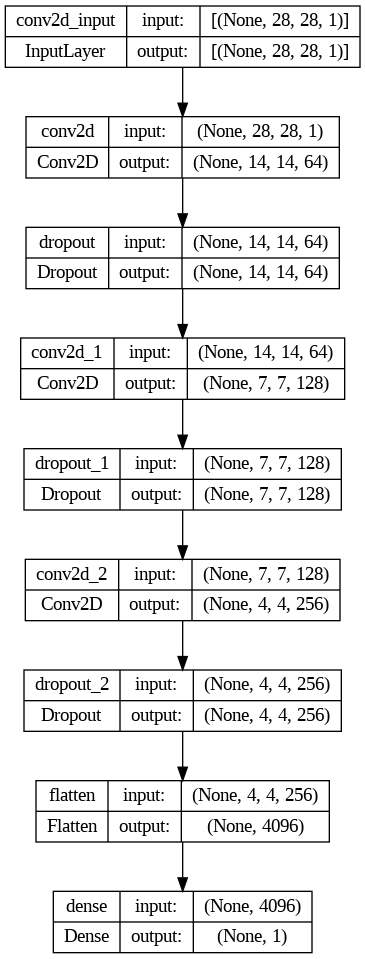

In [ ]:
# discriminator
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
	activation='relu', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', 
	activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', 
	activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(lr=0.0004),
                      metrics=['accuracy'])

discriminator.summary()
from tensorflow.keras.utils import plot_model
plot_model(discriminator, show_shapes=True)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                    

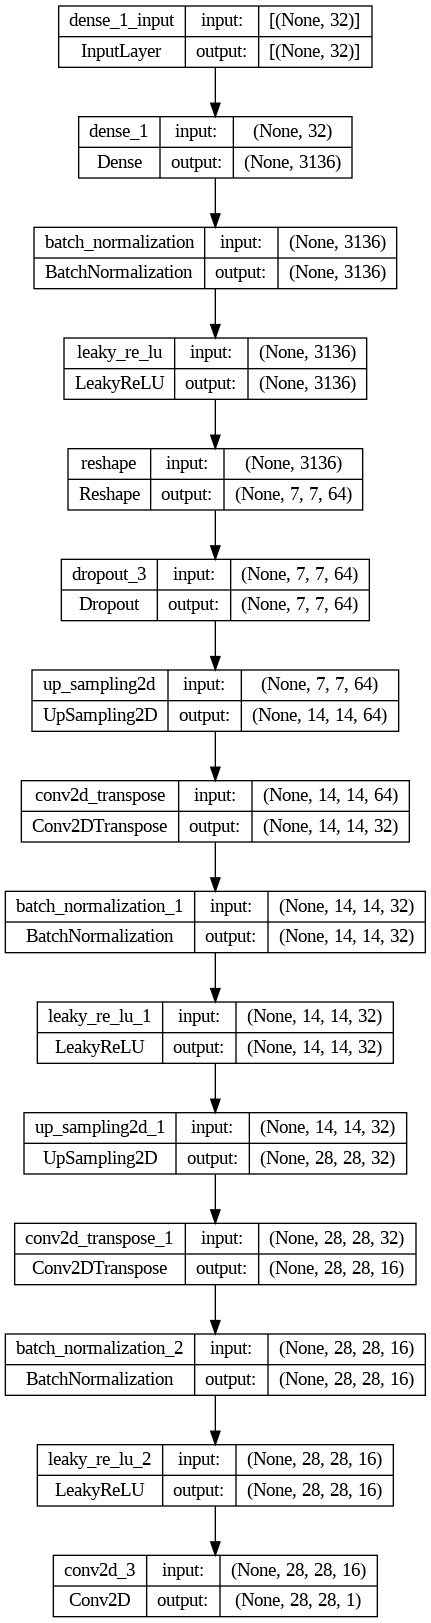

In [ ]:
# generator
def make_generator():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(7*7*64, input_shape=(Z_DIMENSIONS,)))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7, 7, 64)))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.UpSampling2D())  # UpSampling2D(size=(2, 2),...
    model.add(tf.keras.layers.Conv2DTranspose(32,
                            kernel_size=5, padding='same',
                            activation=None,))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2DTranspose(16,
                            kernel_size=5, padding='same',
                            activation=None,))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, kernel_size=5, padding='same',
                   activation='sigmoid'))
    return model

generator = make_generator()
generator.summary()
# from tensorflow.keras.utils import plot_model
plot_model(generator, show_shapes=True)



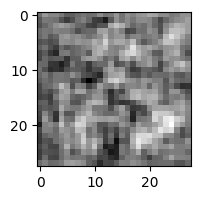

In [ ]:
# Generated sample
noise = tf.random.normal([1, Z_DIMENSIONS])  # one batch of noise
generated_image = generator(noise, training=False)
plt.figure(figsize=(2,2))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')



1/1 [==============================] - 0s 276ms/step


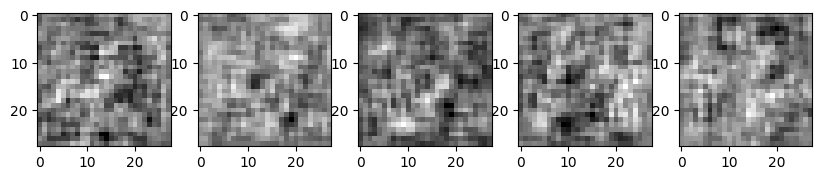

In [ ]:
# fake images from generator
noise = np.random.uniform(-1.0, 1.0,
                          size=[5, Z_DIMENSIONS])
generated_image = generator.predict(noise)
plt.figure(figsize=(10,10))
for i in range(generated_image.shape[0]):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_image[i, :, :, 0],
               cmap='gray')
plt.show()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         180673    
                                                                 
 sequential (Sequential)     (None, 1)                 1030145   
                                                                 
Total params: 1,210,818
Trainable params: 174,305
Non-trainable params: 1,036,513
_________________________________________________________________


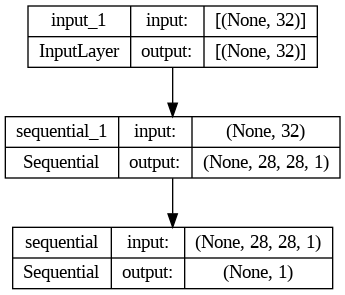

In [ ]:
# GAN model
z = tf.keras.layers.Input(shape=(Z_DIMENSIONS,))
fake_image = generator(z)
discriminator.trainable = False
prediction = discriminator(fake_image)
gan_model = tf.keras.models.Model(z, prediction)

gan_model.compile(loss='binary_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(lr=0.0004),
                          metrics=['accuracy'])

gan_model.summary()
plot_model(gan_model, show_shapes=True)



1/1 [==============================] - 0s 18ms/step


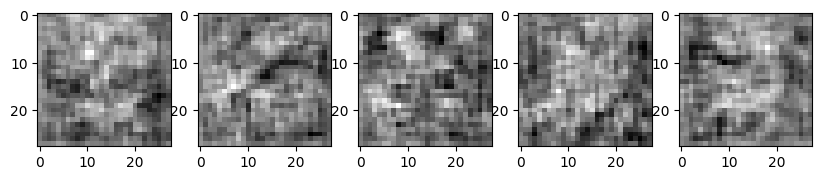

1/1 [==============================] - 0s 29ms/step


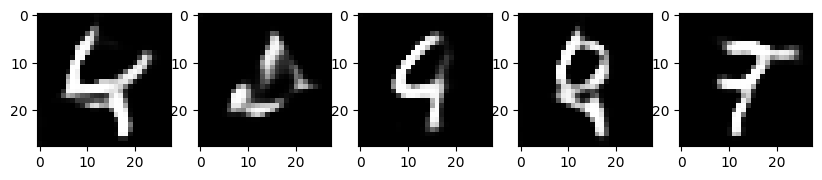

1/1 [==============================] - 0s 18ms/step


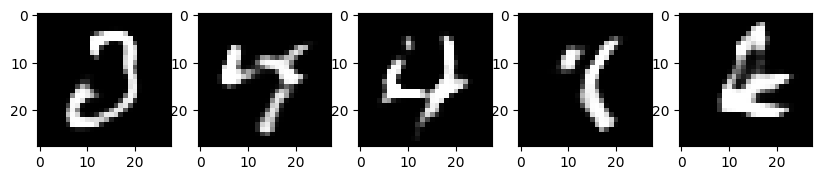

1/1 [==============================] - 0s 22ms/step


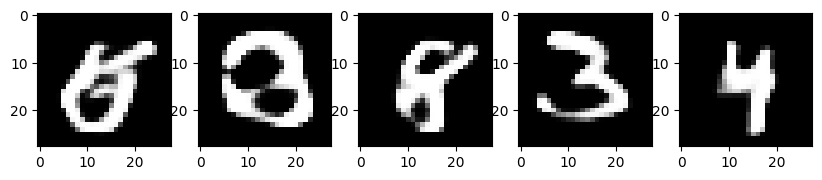

1/1 [==============================] - 0s 17ms/step


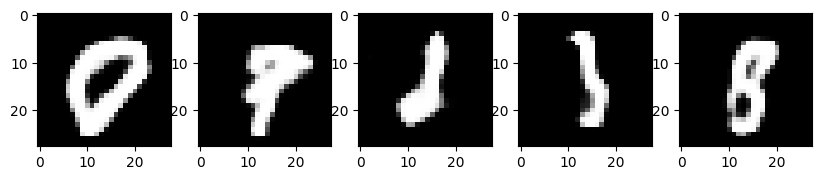

1/1 [==============================] - 0s 21ms/step


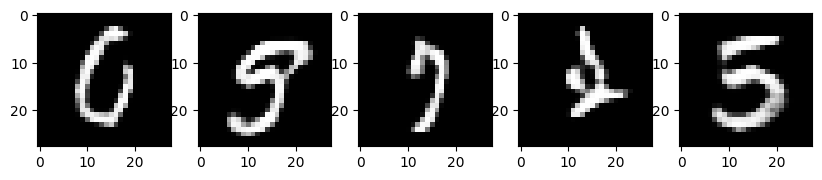

In [ ]:
# Train GAN
def train_gan():
    for i in range(EPOCHS+1):
        real_images = np.reshape(
            data[np.random.choice(data.shape[0],
                                  BATCH_SIZE,
                                  replace=False)], (BATCH_SIZE,28,28,1))
        fake_images = generator.predict(
           np.random.uniform(-1.0, 1.0,
                             size=[BATCH_SIZE, Z_DIMENSIONS]))

        x = np.concatenate((real_images,fake_images))

        y = np.ones([2*BATCH_SIZE,1])
        y[BATCH_SIZE:,:] = 0

        discriminator.train_on_batch(x, y)
 
        noise = np.random.uniform(-1.0, 1.0, size=[BATCH_SIZE, Z_DIMENSIONS])
        y = np.ones([BATCH_SIZE,1])

        gan_model.train_on_batch(noise, y)
 
        if i%1000 == 0:
           noise = np.random.uniform(-1.0, 1.0,
                                     size=[5, Z_DIMENSIONS])
           generated_image = generator.predict(noise)
           plt.figure(figsize=(10,10))
           for i in range(generated_image.shape[0]):
               plt.subplot(1, 5, i+1)
               plt.imshow(generated_image[i, :, :, 0],
                          cmap='gray')
           plt.show()

train_gan()



## Test GAN model

1/1 [==============================] - 0s 18ms/step


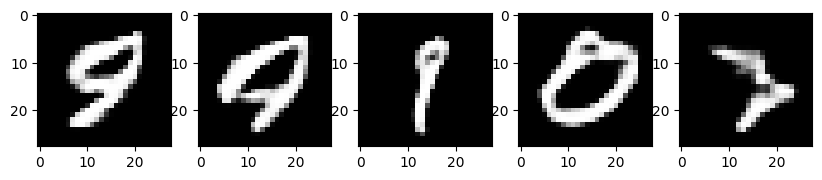

In [ ]:
# fake images from trained generator
noise = np.random.uniform(-1.0, 1.0,
                          size=[5, Z_DIMENSIONS])
generated_image = generator.predict(noise)
plt.figure(figsize=(10,10))
for i in range(generated_image.shape[0]):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_image[i, :, :, 0],
               cmap='gray')
plt.show()

